<a href="https://colab.research.google.com/github/AndreasSjolander/NLFEM/blob/main/NonLinearFEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-Linear Finite Element Model
In this notebook, a simple script is provided to show the response for a single element finite element model with a non-linear softening response.

1. Non-Linear Example of a Bi-Linear Spring Stiffness Problem
2. Example of Convex Non-Linear Spring Problem

The basic coding is provided using Gemini, Googles open AI model. Explanations to the code to improve understanding has been manually written.

# Non-Linear Example of a Bi-Linear Spring Stiffness Problem

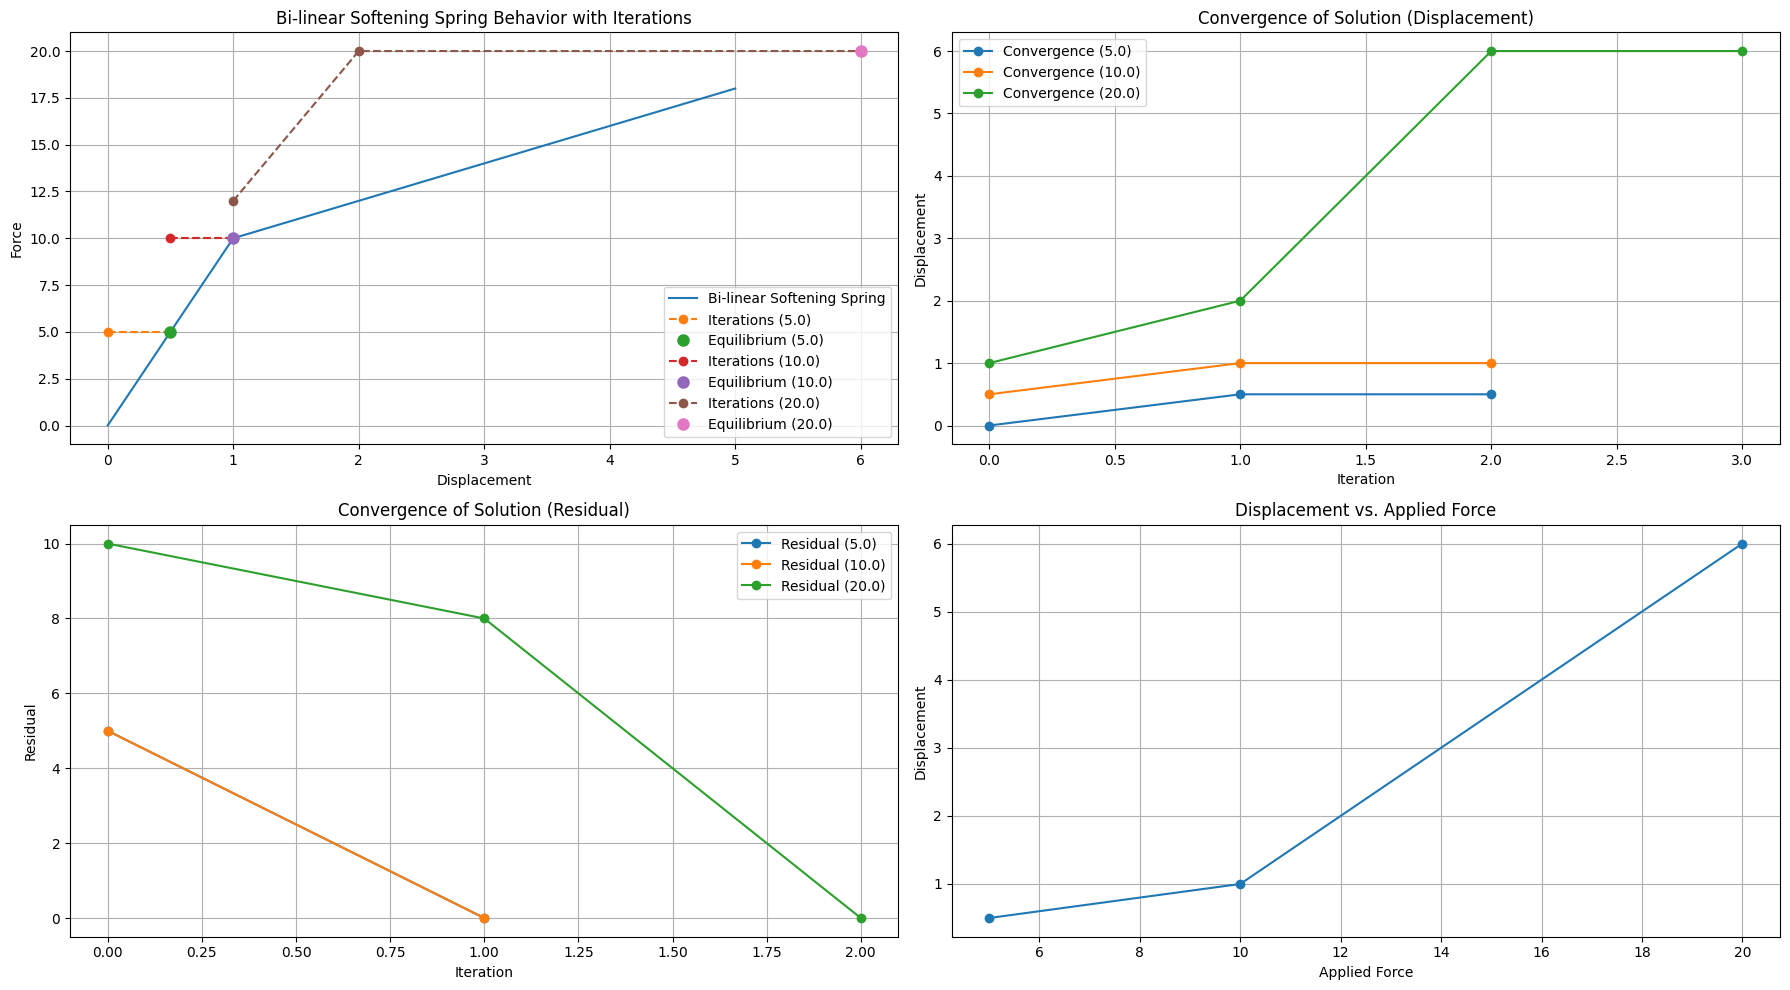

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define the Non-Linear Spring Element with Bi-Linear Softening ---

def spring_force(displacement, k1, k2, displacement_threshold):
    """Calculates the force in a bi-linear softening spring based on the user-
    defined threshold value for displacement"""
    if abs(displacement) <= displacement_threshold:
        return k1 * displacement
    else:
        return k1 * np.sign(displacement) * displacement_threshold + k2 * (displacement - np.sign(displacement) * displacement_threshold)

def spring_stiffness(displacement, k1, k2, displacement_threshold):
    """Returns the stiffness of the bi-linear softening spring."""
    if abs(displacement) <= displacement_threshold:
        return k1
    else:
        return k2

# --- Problem Setup ---
"""
k1 = Initial stiffness of spring
k2 = Second stiffness value of spring
displacement_threshold = Threshold displacement value for softening
"""
k1 = 10.0
k2 = 2.0
displacement_threshold = 1.0

# --- Solve for Equilibrium using Newton-Raphson in Steps ---
"""
To solve the non-linear problem, the following functions are defined:
residual = calculates the residual force imbalance
jacobian = is the derivative of the residual with respect to the displacement.
newton_raphson = solver for equilibrium using the Newton-Raphson method

Note that in this case, the Jacobian is simply the stiffness of the spring.
The residual is defined as:
residual(displacement) = spring_force(displacement) - applied_force
its derivative is:
jacobian = d(residual) / d(displacement)
jacobian = d(spring_force(displacement) - applied_force) / d(displacement)

since the applied force is constant, its derivative is zero and the jacobian becoms:
jacobian = d(spring_force(displacement)) / d(displacement)

Hence, the jacobian is in this example defined as the rate of change in force
with respect to displacement which is the stiffness of the spring.
"""

def residual(displacement, k1, k2, displacement_threshold, applied_force):
    """Calculates the residual (force imbalance)."""
    return spring_force(displacement, k1, k2, displacement_threshold) - applied_force

def jacobian(displacement, k1, k2, displacement_threshold):
    """Calculates the Jacobian (derivative of residual)."""
    return spring_stiffness(displacement, k1, k2, displacement_threshold)

def newton_raphson(initial_guess, k1, k2, displacement_threshold, applied_force, tolerance=1e-6, max_iterations=100):
    """Solves for equilibrium using the Newton-Raphson method."""
    displacement = initial_guess
    convergence_history = [displacement]
    residual_history = []
    force_history = []  # Track force at each iteration
    for _ in range(max_iterations):
        r = residual(displacement, k1, k2, displacement_threshold, applied_force)
        j = jacobian(displacement, k1, k2, displacement_threshold)
        delta_displacement = -r / j
        displacement += delta_displacement
        convergence_history.append(displacement)
        residual_history.append(abs(r))
        force_history.append(spring_force(displacement, k1, k2, displacement_threshold))  # Store the force
        if abs(r) < tolerance:
            break
    return displacement, convergence_history, residual_history, force_history  # Return force history

# --- Solve in Steps ---

# Applied force
applied_forces = [5.0, 10.0, 20.0]
# Define vectors to store displacement, convergence, force and residual for plot
displacement_solutions = []
convergence_histories = []
residual_histories = []
force_histories = []
# Initial displacement guess
initial_guess = 0.0  # Initial guess for the first step

for force in applied_forces:
    displacement_solution, convergence_history, residual_history, force_history = newton_raphson(
        initial_guess, k1, k2, displacement_threshold, force
    )
    displacement_solutions.append(displacement_solution)
    convergence_histories.append(convergence_history)
    residual_histories.append(residual_history)
    force_histories.append(force_history)  # Store force history
    initial_guess = displacement_solution  # Use previous solution as initial guess

# --- Plot the Results ---
# Define the displacement vector to use
displacements = np.linspace(0, 5, 200)
forces = [spring_force(d, k1, k2, displacement_threshold) for d in displacements]

plt.figure(figsize=(18, 10))

# Force-Displacement Curve
plt.subplot(2, 2, 1)
plt.plot(displacements, forces, label='Bi-linear Softening Spring')

for i, force in enumerate(applied_forces):
    # Plot iterations for each load step
    disp_history = convergence_histories[i]
    force_history = force_histories[i]

    # Ensure disp_history and force_history have the same length
    min_len = min(len(disp_history), len(force_history))
    disp_history = disp_history[:min_len]  # Trim to the minimum length
    force_history = force_history[:min_len]  # Trim to the minimum length

    plt.plot(disp_history, force_history, marker='o', linestyle='--', label=f'Iterations ({applied_forces[i]})')
    plt.plot(displacement_solutions[i], force, 'o', markersize=8, label=f'Equilibrium ({force})')  # Emphasize equilibrium


plt.xlabel('Displacement')
plt.ylabel('Force')
plt.title('Bi-linear Softening Spring Behavior with Iterations')
plt.grid(True)
plt.legend()

# Convergence History (Displacement)
plt.subplot(2, 2, 2)
for i, history in enumerate(convergence_histories):
    plt.plot(history, marker='o', linestyle='-', label=f'Convergence ({applied_forces[i]})')
plt.xlabel('Iteration')
plt.ylabel('Displacement')
plt.title('Convergence of Solution (Displacement)')
plt.grid(True)
plt.legend()

# Residual History
plt.subplot(2, 2, 3)
for i, history in enumerate(residual_histories):
    plt.plot(history, marker='o', linestyle='-', label=f'Residual ({applied_forces[i]})')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title('Convergence of Solution (Residual)')
plt.grid(True)
plt.legend()

# Displacement vs. Load
plt.subplot(2, 2, 4)
plt.plot(applied_forces, displacement_solutions, marker='o', linestyle='-')
plt.xlabel('Applied Force')
plt.ylabel('Displacement')
plt.title('Displacement vs. Applied Force')
plt.grid(True)

plt.tight_layout()
plt.show()

# Example of Convex Non-Linear Spring Problem

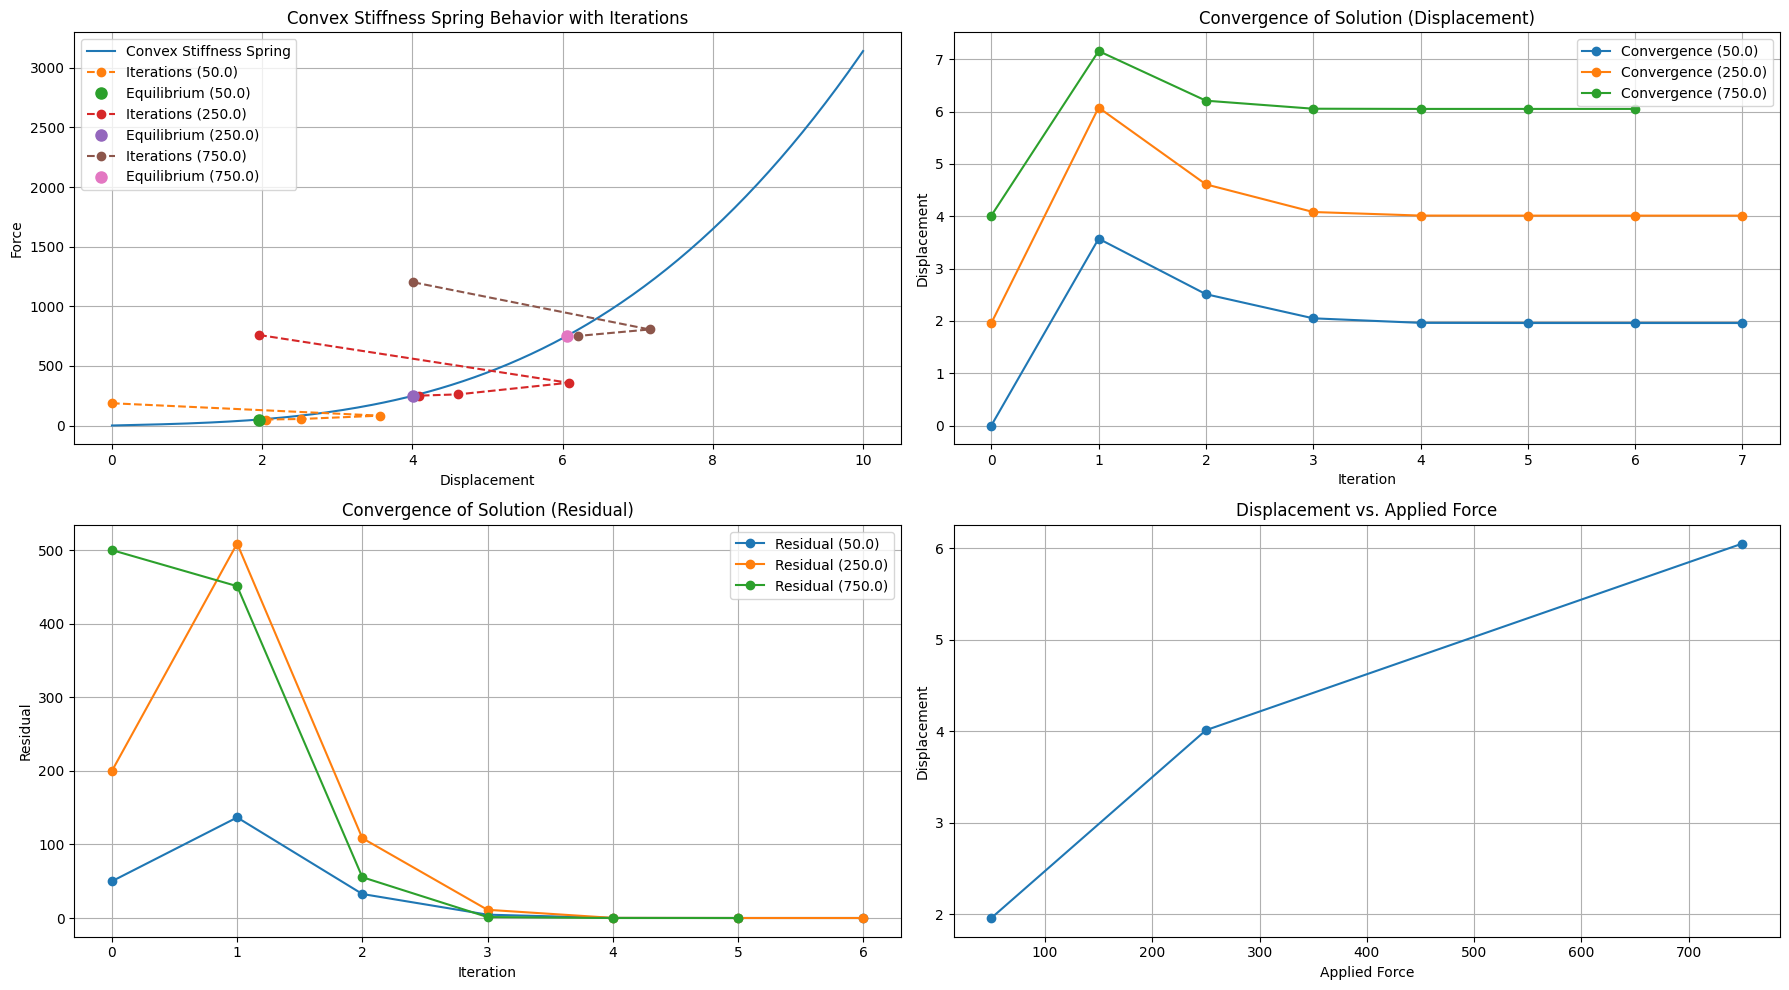

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define the Non-Linear Spring Element with Convex Stiffness ---

def spring_force(displacement, k1, k2):
    """Calculates the force in a spring with convex stiffness."""
    return k1 * displacement + k2 * displacement**3  # Example convex stiffness

def spring_stiffness(displacement, k1, k2):
    """Calculates the stiffness of the convex spring."""
    return k1 + 3 * k2 * displacement**2

# --- Problem Setup ---

k1 = 14.0
k2 = 3.0  # Adjust k2 to control the degree of convexity

# --- Solve for Equilibrium using Newton-Raphson in Steps ---

def residual(displacement, k1, k2, applied_force):
    """Calculates the residual (force imbalance)."""
    return spring_force(displacement, k1, k2) - applied_force

def jacobian(displacement, k1, k2):
    """Calculates the Jacobian (derivative of residual)."""
    return spring_stiffness(displacement, k1, k2)

def newton_raphson(initial_guess, k1, k2, applied_force, tolerance=1e-6, max_iterations=100):
    """Solves for equilibrium using the Newton-Raphson method."""
    displacement = initial_guess
    convergence_history = [displacement]
    residual_history = []
    force_history = []
    for _ in range(max_iterations):
        r = residual(displacement, k1, k2, applied_force)
        j = jacobian(displacement, k1, k2)
        delta_displacement = -r / j
        displacement += delta_displacement
        convergence_history.append(displacement)
        residual_history.append(abs(r))
        force_history.append(spring_force(displacement, k1, k2))
        if abs(r) < tolerance:
            break
    return displacement, convergence_history, residual_history, force_history

# --- Solve in Steps ---

applied_forces = [50.0, 250.0, 750.0]
displacement_solutions = []
convergence_histories = []
residual_histories = []
force_histories = []
initial_guess = 0.0

for force in applied_forces:
    displacement_solution, convergence_history, residual_history, force_history = newton_raphson(
        initial_guess, k1, k2, force
    )
    displacement_solutions.append(displacement_solution)
    convergence_histories.append(convergence_history)
    residual_histories.append(residual_history)
    force_histories.append(force_history)
    initial_guess = displacement_solution

# --- Plot the Results ---

displacements = np.linspace(0, 10, 200)  # Adjusted displacement range
forces = [spring_force(d, k1, k2) for d in displacements]

plt.figure(figsize=(18, 10))

# Force-Displacement Curve
plt.subplot(2, 2, 1)
plt.plot(displacements, forces, label='Convex Stiffness Spring')

for i, force in enumerate(applied_forces):
    # Plot iterations for each load step
    disp_history = convergence_histories[i]
    force_history = force_histories[i]

    # Ensure disp_history and force_history have the same length
    min_len = min(len(disp_history), len(force_history))
    disp_history = disp_history[:min_len]  # Trim to the minimum length
    force_history = force_history[:min_len]  # Trim to the minimum length

    plt.plot(disp_history, force_history, marker='o', linestyle='--', label=f'Iterations ({applied_forces[i]})')
    plt.plot(displacement_solutions[i], force, 'o', markersize=8, label=f'Equilibrium ({force})')  # Emphasize equilibrium

plt.xlabel('Displacement')
plt.ylabel('Force')
plt.title('Convex Stiffness Spring Behavior with Iterations')
plt.grid(True)
plt.legend()

# Convergence History (Displacement)
plt.subplot(2, 2, 2)
for i, history in enumerate(convergence_histories):
    plt.plot(history, marker='o', linestyle='-', label=f'Convergence ({applied_forces[i]})')
plt.xlabel('Iteration')
plt.ylabel('Displacement')
plt.title('Convergence of Solution (Displacement)')
plt.grid(True)
plt.legend()

# Residual History
plt.subplot(2, 2, 3)
for i, history in enumerate(residual_histories):
    plt.plot(history, marker='o', linestyle='-', label=f'Residual ({applied_forces[i]})')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title('Convergence of Solution (Residual)')
plt.grid(True)
plt.legend()

# Displacement vs. Load
plt.subplot(2, 2, 4)
plt.plot(applied_forces, displacement_solutions, marker='o', linestyle='-')
plt.xlabel('Applied Force')
plt.ylabel('Displacement')
plt.title('Displacement vs. Applied Force')
plt.grid(True)

plt.tight_layout()
plt.show()